### MAIN NOTEBOOK DE ARMADO DE DATASET PARA SEGMENTACIÓN ÍNTEGRA -> CÁLCULO DE VOLUMEN (después de probar todo lo posible)

In [1]:
import os
import nibabel as nib
import numpy as np
import cv2
import torchio as tio
import matplotlib.pyplot as plt
import SimpleITK as sitk
from PIL import Image
import elasticdeform
from sklearn.model_selection import train_test_split
import shutil

### INFO GENERAL DEL DATASET

Hay 6 datasets rejuntados -> total de 116 pacientes -> todas secuencias T2 con sus máscaras anexas en formato .nii <br>
Todo los dataset tienen secuencias mixtas en tamaño de pixel y cantidad de slices. <br>
Además, algunas tienen endorectal coil. <br>
Mucha varianza en el brillo, incluso dentro del mismo dataset.

#### PREPROCESADO

A priori, se renombraron todos las secuencias y sus máscaras en un formato conveniente. <br>
1 - Se realizó un flip de 90° ya que las imágenes viniero rotadas. Además se binarizaron las máscaras ya que algunos datasets tenian multiclase. <br>
2 - Se aplicó Bias Correction (N4ITK) a todas las secuencias (por separado). <br>
3 - Se separaron los 116 pacientes en 10% test (12), del 90% restante (104), 75% train (77), 25% validation (27).
- Se separó a nivel paciente siguiendo los criterios del "Checklist for Artificial Intelligence in Medical Imaging" (CLAIM). <br>








---
RENAME

In [ ]:
fp = r"C:\Users\Pier\Desktop\PFI_main\ds_mezcla_segmentacion integra\nuevas"
fp2 = r"C:\Users\Pier\Desktop\PFI_main\ds_mezcla_segmentacion integra\nuevas2"
allfiles = os.listdir(fp)
allfilesfinales = os.listdir(fp2)
cont = int(len(allfilesfinales)/2)
cont2 = int(len(allfilesfinales)/2)
for file in sorted(allfiles):
    print(file)
    if ("segmentation" in file ) or ("Segmentation" in file): 
        cont+=1
        os.rename(os.path.join(fp,file),os.path.join(fp2,"segmentacion_"+str(cont).zfill(3)+".nii"))
    else:
        cont2+=1
        os.rename(os.path.join(fp,file),os.path.join(fp2,"sujeto_"+str(cont2).zfill(3)+".nii"))


---
FLIP Y BINARIZADO 

In [ ]:
fp = r"C:\Users\Pier\Desktop\PFI_main\ds_mezcla_segmentacion integra\nuevas2"
fp2 = r"C:\Users\Pier\Desktop\PFI_main\ds_mezcla_segmentacion integra\nuevas"
allfiles = os.listdir(fp)
for file in sorted(allfiles):
    print(file)
    x = nib.load(os.path.join(fp,file))
    img = x.get_fdata()
    img = np.rot90(img,3)
    if "segmentacion" in file: img = np.any(img)
    nifti = nib.Nifti1Image(img, header = x.header, affine= x.affine)
    nib.save(nifti, os.path.join(fp2, file))  

---
BIAS CORRECTION

In [ ]:
fp = r"C:\Users\Pier\Desktop\PFI_main\ds_mezcla_segmentacion integra\aa"
fp2 = r"C:\Users\Pier\Desktop\PFI_main\ds_mezcla_segmentacion integra\flipped"
allfiles = os.listdir(fp)
for file in sorted(allfiles):
    if "sujeto" in file:
        x = nib.load(os.path.join(fp,file))
        img = x.get_fdata()
        inputImage = sitk.ReadImage(os.path.join(fp,file))
        maskImage = sitk.OtsuThreshold(inputImage,0,1,200)
        inputImage = sitk.Cast(inputImage,sitk.sitkFloat32)
        corrector = sitk.N4BiasFieldCorrectionImageFilter()
        output = corrector.Execute(inputImage,maskImage)
        newimg = np.transpose(sitk.GetArrayViewFromImage(output))
        nifti = nib.Nifti1Image(newimg, header = x.header, affine= x.affine)
        nib.save(nifti, os.path.join(fp2, file))  
    else:
        shutil.copy2(os.path.join(fp,file), os.path.join(fp2,file))

---
SPLIT TRAIN-VALIDATION-TEST

In [3]:
fp1 = r"C:\Users\Pier\Desktop\PFI_main\ds_mezcla_segmentacion integra\bias_corrected_sec\sujetos"
fp2 = r"C:\Users\Pier\Desktop\PFI_main\ds_mezcla_segmentacion integra\bias_corrected_sec\mascaras"
sujetos = os.listdir(fp1)
segmentaciones = os.listdir(fp2)
suj_train,suj_test,seg_train,seg_test = train_test_split(sujetos,segmentaciones,train_size=0.9,random_state=23) #random_state = 23

In [8]:

fp1 = r"C:\Users\Pier\Desktop\PFI_main\ds_mezcla_segmentacion integra\bias_corrected_sec\sujetos"
fp0 = r"C:\Users\Pier\Desktop\PFI_main\ds_mezcla_segmentacion integra\bias_corrected_sec\mascaras"
fp2 = r"C:\Users\Pier\Desktop\PFI_main\DS_VOLUMEN\main\train_data\sujetos"
fp3 = r"C:\Users\Pier\Desktop\PFI_main\DS_VOLUMEN\main\test_data\sujetos"
fp4 = r"C:\Users\Pier\Desktop\PFI_main\DS_VOLUMEN\main\train_data\mascaras"
fp5 = r"C:\Users\Pier\Desktop\PFI_main\DS_VOLUMEN\main\test_data\mascaras"

for file in suj_train:
    shutil.copy2(os.path.join(fp1,file), os.path.join(fp2,file))
for file in suj_test:
    shutil.copy2(os.path.join(fp1,file), os.path.join(fp3,file))
for file in seg_train:
    shutil.copy2(os.path.join(fp0,file), os.path.join(fp4,file))
for file in seg_test:
    shutil.copy2(os.path.join(fp0,file), os.path.join(fp5,file))

In [9]:
fp1 = r"C:\Users\Pier\Desktop\PFI_main\DS_VOLUMEN\main\train_data\sujetos"
fp2 = r"C:\Users\Pier\Desktop\PFI_main\DS_VOLUMEN\main\train_data\mascaras"
sujetos = os.listdir(fp1)
segmentaciones = os.listdir(fp2)
suj_train,suj_val,seg_train,seg_val = train_test_split(sujetos,segmentaciones,train_size=0.75,random_state=23) #random_state = 23

In [10]:
fp1 = r"C:\Users\Pier\Desktop\PFI_main\DS_VOLUMEN\main\train_data\sujetos"
fp0 = r"C:\Users\Pier\Desktop\PFI_main\DS_VOLUMEN\main\train_data\mascaras"
fp3 = r"C:\Users\Pier\Desktop\PFI_main\DS_VOLUMEN\main\validation_data\sujetos"
fp5 = r"C:\Users\Pier\Desktop\PFI_main\DS_VOLUMEN\main\validation_data\mascaras"

for file in suj_val:
    shutil.move(os.path.join(fp1,file), os.path.join(fp3,file))
for file in seg_val:
    shutil.move(os.path.join(fp0,file), os.path.join(fp5,file))

In [ ]:
fp = r"C:\Users\Pier\Desktop\PFI_main\ds_mezcla_segmentacion integra\bias_corrected_sec\mascaras"
allfiles = os.listdir(fp)
allz = 0
allnz = 0

for file in allfiles:
    if "segmentacion" in file:
        x = nib.load(os.path.join(fp,file))
        x = x.get_fdata()
        for slice in range(np.size(x,2)):
            if not np.any(x[:,:,slice]): allz+=1
            else: allnz+=1

print(allz,allnz) #2020 1867 -> 48% de máscaras tienen próstata

In [13]:
fp0 = [r"C:\Users\Pier\Desktop\PFI_main\DS_VOLUMEN\main\train_data\mascaras",
       r"C:\Users\Pier\Desktop\PFI_main\DS_VOLUMEN\main\validation_data\mascaras",
       r"C:\Users\Pier\Desktop\PFI_main\DS_VOLUMEN\main\test_data\mascaras"]
for fp in fp0:
    allfiles = os.listdir(fp)
    allz = 0
    allnz = 0
    for file in allfiles:
        if "segmentacion" in file:
            x = nib.load(os.path.join(fp,file))
            x = x.get_fdata()
            for slice in range(np.size(x,2)):
                if not np.any(x[:,:,slice]): allz+=1
                else: allnz+=1
    print(allz,allnz,allz/(allz+allnz)*100) #cantidad de mascaras SIN prostata / CON prostata / SIN en % -> aprox 50+/-3% (dataset balanceado)

1416 1249 53.13320825515947
416 410 50.363196125908
188 208 47.474747474747474


---
SEPARACION DE SLICES EN .PNG

Para normalizar el dataset

In [2]:
def checknottest(filename:str):
    in_test = ["006","010","021","025","030","048","056","072","088","094","098","102"] #sujetos en test (que no quiero usar para calcular datos)
    for n in in_test:
        if n in file: return False
    return True

fp = r"C:\Users\Pier\Desktop\PFI_main\ds_mezcla_segmentacion integra\bias_corrected_sec\sujetos"
allfiles = os.listdir(fp)
#means = []
#maxs = []
#mins = []
todas = []
for file in allfiles:
    if (("sujeto" in file) and (checknottest(file))):
        x = nib.load(os.path.join(fp,file))
        x = x.get_fdata()
        for slice in range(np.size(x,2)):
            #maxs.append(np.max(x[63:319,63:319,slice]))
            #means.append(np.mean(x[63:319,63:319,slice]))
            #mins.append(np.min(x[63:319,63:319,slice]))
            todas.append(x[63:319,63:319,slice])

#media = np.mean(means)
#maxx = np.max(maxs)
#minn = np.min(mins)
#print(media,maxx,minn)

In [3]:
tt = np.ravel(todas)

In [11]:
tt.shape()

AttributeError: 'list' object has no attribute 'shape'

In [5]:
p1 = np.percentile(tt,99.95)

In [6]:
def c(x):
    if x>=p1: return p1
    else: return x

In [9]:
tt = list(map(c, tt))

In [25]:
plt.hist(tt,bins=10000,log=True)
plt.show()

KeyboardInterrupt: 

In [13]:
plt.hist(tt,bins=256,log=True)
plt.show()

In [15]:
np.percentile(tt,99.95)

0.12122609411463711

In [29]:
cont = 0
for n in maxs: 
    if n > 12000: cont+=1
print(cont)

43


In [26]:
np.mean(maxs)

2149.499870805131

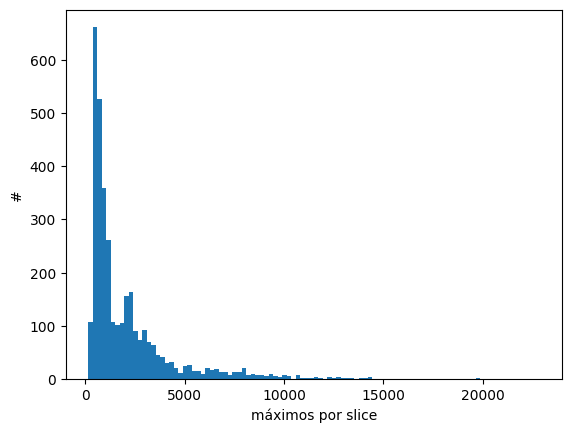

In [5]:
plt.hist(maxs,bins=100)
plt.xlabel("máximos por slice")
plt.ylabel("#")
plt.show()

In [36]:
fp = r"C:\Users\Pier\Desktop\PFI_main\ds_mezcla_segmentacion integra\bias_corrected_sec\sujetos"
allfiles = os.listdir(fp)
mri_max = 0
mri_min = 0
means = []
variances = []
for file in allfiles:
    if (("sujeto" in file) and (checknottest(file))):
        x = nib.load(os.path.join(fp,file))
        x = x.get_fdata()
        for slice in range(np.size(x,2)):
            var = np.std((x[63:319,63:319,slice]))
            variances.append(var)

desviacion = np.std(variances)
print(desviacion)

147.58304673764198


In [ ]:
fp = r"C:\Users\Pier\Desktop\PFI_main\DS_VOLUMEN\main\train_data\sujetos"
#fp = r"C:\Users\Pier\Desktop\PFI_main\DS_VOLUMEN\main\train_data\mascaras"
allfiles = os.listdir(fp)
cont = 0
cont2 = 0

for file in sorted(allfiles):
    x = nib.load(os.path.join(fp,file))
    y = x.get_fdata()
    if "sujeto" in file:
        for slices in range(np.size(y,2)):
            cont+=1
            img = (y[63:319,63:319,slices]/2116.231308269967)*255 
            cv2.imwrite(fp+"\img\img_sujeto_"+str(cont).zfill(4)+".png", img)
    else:
        for slices in range(np.size(y,2)):
            cont2+=1
            img = y[63:319,63:319,slices]*255
            cv2.imwrite(fp+"\img\img_segmentacion_"+str(cont2).zfill(4)+".png", img)